<a href="https://colab.research.google.com/github/kjahan/learning_to_rank/blob/develop/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download MSLR dataset

https://github.com/lezzhov/learning_to_rank/tree/main/learning_to_rank/data

In [ ]:
!mkdir data
!wget -P /content/data https://raw.githubusercontent.com/lezzhov/learning_to_rank/refs/heads/main/learning_to_rank/data/test.txt
!wget -P /content/data https://raw.githubusercontent.com/lezzhov/learning_to_rank/refs/heads/main/learning_to_rank/data/train.txt
!wget -P /content/data https://raw.githubusercontent.com/lezzhov/learning_to_rank/refs/heads/main/learning_to_rank/data/vali.txt

--2024-12-02 02:13:42--  https://raw.githubusercontent.com/lezzhov/learning_to_rank/refs/heads/main/learning_to_rank/data/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31307350 (30M) [text/plain]
Saving to: ‘/content/data/test.txt’

test.txt            100%[===================>]  29.86M   166MB/s    in 0.2s    

2024-12-02 02:13:43 (166 MB/s) - ‘/content/data/test.txt’ saved [31307350/31307350]

--2024-12-02 02:13:43--  https://raw.githubusercontent.com/lezzhov/learning_to_rank/refs/heads/main/learning_to_rank/data/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
H

In [ ]:
!ls -l data

total 93988
-rw-r--r-- 1 root root 31307350 Dec  2 02:13 test.txt
-rw-r--r-- 1 root root 34322657 Dec  2 02:13 train.txt
-rw-r--r-- 1 root root 30607789 Dec  2 02:13 vali.txt


## Try Linear Regression for ranking

https://github.com/kjahan/learning_to_rank/blob/develop/01-intro-regression.ipynb


### Learning to Rank with Linear Regression

In this notebook we load in the data set and train a linear regression model on the data. We then use this to rank data sets.

In later notebooks we implement more sophisticated algorithms for Learning to Rank on the same data set.

The data set we use here is the MSLR-WEB10K data set, which is open sourced by Mircosoft and can be downloaded from here. We will only work with Fold1 of the data set. This notebook assumes that the contents of Fold1 are stored in a subdirectory named 'data'. If your data is stored elsewhere you will need to ammend the paths appropriately.

https://www.microsoft.com/en-us/research/project/mslr/

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
train = pd.read_csv("/content/data/train.txt", header=None, sep=" ")

# Drop last column
train = train.drop(138, axis=1)

# Drop rows with any NaN values
train.dropna(inplace=True)

print(train.shape)

# Count total NaNs in the DataFrame
total_nans = train.isna().sum().sum()
print(total_nans)

(29648, 138)
0


In [ ]:
train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,1,qid:3613,1:4,2:0,3:2,4:0,5:4,6:1,7:0,8:0.50000,...,127:101,128:18,129:0,130:256,131:10674,132:3,133:4,134:0,135:0,136:0
1,0,qid:3613,1:4,2:0,3:4,4:0,5:4,6:1,7:0,8:1,...,127:55,128:5,129:2,130:209,131:15137,132:2,133:3,134:0,135:0,136:0
2,0,qid:3613,1:4,2:0,3:2,4:0,5:4,6:1,7:0,8:0.50000,...,127:72,128:6,129:0,130:154,131:6768,132:1,133:4,134:0,135:0,136:0
3,1,qid:3613,1:4,2:0,3:2,4:0,5:4,6:1,7:0,8:0.50000,...,127:101,128:7,129:0,130:222,131:10707,132:2,133:4,134:0,135:0,136:0
4,0,qid:3613,1:4,2:0,3:3,4:0,5:4,6:1,7:0,8:0.75000,...,127:43,128:227,129:2,130:222,131:13030,132:1,133:4,134:0,135:0,136:0


## Review data

In [ ]:
np.random.seed(0xc00f33e)
df_samp = train.sample(4)

In [ ]:
df_samp.head(4)

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
26800,0,qid:6913,1:2,2:0,3:0,4:0,5:2,6:1,7:0,8:0,...,127:50,128:876,129:13,130:62048,131:52906,132:1,133:4,134:0,135:0,136:0
6110,0,qid:4078,1:3,2:0,3:1,4:1,5:3,6:1,7:0,8:0.333333,...,127:24,128:0,129:2,130:50756,131:9625,132:7,133:19,134:0,135:5,136:22.3
5173,0,qid:3958,1:1,2:0,3:0,4:0,5:1,6:1,7:0,8:0,...,127:71,128:0,129:0,130:221,131:48367,132:1,133:1,134:0,135:0,136:0
3361,1,qid:3688,1:3,2:0,3:3,4:1,5:3,6:1,7:0,8:1,...,127:82,128:0,129:0,130:681,131:65535,132:5,133:1,134:0,135:0,136:0


## Data Schema

`Each row represents a query - document pair.`

`Column '0' is an integer taking values from 0 to 4, where 0 denotes "this document is irrelevant for this query", and 4 denotes "this document is perfectly relevant for this query".`

`Column '1' holds an integer identifying the query and is of the form 'qid:int'.`

`Columns '2' through to '137' hold the features for the query - document pair. The data in these columns are of the form 'feature_id:feature_value'. Full details about each of the features can be found here.`

`Finally, column '138' is NaN for every row. (It is an artifact of the way we split the data set into columns.)`

## Processing the data

We want to do three things to the data frame in order to get it into an easier form to work with:

1. replace 'qid:int' with 'int' in column '1'
2. replace 'feature_id:feature_value' with 'feature_value' for all entries in columns '2' to '137'
3. delete column '138'

In [ ]:
def extract_qid(qid_str):
    return qid_str[4:]

def extract_val(feat):
    return feat.split(':')[1]

In [ ]:
df_samp[1] = df_samp[1].apply(extract_qid)

df_samp[df_samp.columns[2:]] = df_samp[df_samp.columns[2:]].applymap(extract_val)
#applymap applies the function to every element of the data frame.

<ipython-input-14-5eadc7ca23c0>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_samp[df_samp.columns[2:]] = df_samp[df_samp.columns[2:]].applymap(extract_val)


In [ ]:
df_samp.head()

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
26800,0,6913,2,0,0,0,2,1,0,0,...,50,876,13,62048,52906,1,4,0,0,0
6110,0,4078,3,0,1,1,3,1,0,0.333333,...,24,0,2,50756,9625,7,19,0,5,22.3
5173,0,3958,1,0,0,0,1,1,0,0,...,71,0,0,221,48367,1,1,0,0,0
3361,1,3688,3,0,3,1,3,1,0,1,...,82,0,0,681,65535,5,1,0,0,0


## Transform train DF

We wrap these transformations up in one function which we can then apply to the full training set. We also import and transform the testing set, which we will use to evaluate our model.

In [ ]:
def df_transform(df):
    df[1] = df[1].apply(extract_qid)
    df[df.columns[2:]] = df[df.columns[2:]].applymap(extract_val)
    return df

In [ ]:
train_df = df_transform(train)

<ipython-input-17-c549ff03c05b>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[df.columns[2:]] = df[df.columns[2:]].applymap(extract_val)


In [ ]:
train_df.sample(3)


,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
8160,0,4408,0,0,0,0,0,0,0,0,...,17,0,0,57188,27594,7,10,0,0,0
6750,0,4168,2,0,0,0,2,1,0,0,...,62,542,4,51770,58632,5,2,0,0,0
9900,0,4648,2,0,2,0,2,1,0,1,...,27,0,0,16029,3262,5,7,0,1,1


In [ ]:
test = pd.read_csv("/content/data/test.txt", header=None, sep=" ")

# Drop last column
test = test.drop(138, axis=1)

# Drop rows with any NaN values
test.dropna(inplace=True)

print(test.shape)

# Count total NaNs in the DataFrame
test_total_nans = test.isna().sum().sum()
print(test_total_nans)

(26836, 138)
0


In [ ]:
test.head(5)

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,2,qid:13,1:2,2:0,3:2,4:1,5:2,6:1,7:0,8:1,...,127:35,128:1,129:0,130:266,131:25070,132:28,133:7,134:0,135:0,136:0
1,1,qid:13,1:2,2:0,3:0,4:0,5:2,6:1,7:0,8:0,...,127:17,128:93,129:0,130:153,131:12860,132:65,133:158,134:0,135:0,136:0
2,3,qid:13,1:2,2:0,3:1,4:0,5:2,6:1,7:0,8:0.50000,...,127:19,128:0,129:0,130:153,131:1131,132:112,133:141,134:0,135:0,136:0
3,1,qid:13,1:2,2:0,3:2,4:1,5:2,6:1,7:0,8:1,...,127:50,128:81775,129:0,130:560,131:61224,132:1,133:14,134:0,135:0,136:0
4,0,qid:13,1:1,2:0,3:0,4:0,5:1,6:0.50000,7:0,8:0,...,127:24,128:0,129:0,130:57953,131:15600,132:15,133:12,134:0,135:0,136:0


In [ ]:
test_df = df_transform(test)

<ipython-input-17-c549ff03c05b>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[df.columns[2:]] = df[df.columns[2:]].applymap(extract_val)


In [ ]:
X_test = test_df[test_df.columns[2:]]
y_test = test_df[0]

In [ ]:
y_test[:4]

,0
0,2
1,1
2,3
3,1


## Train LR

We can now go ahead and implement linear regression. We will use the features in columns '2' to '137' as the 'explanatory variables' to predict the relevence value, which is held in column '0'.



In [ ]:
X = train_df[train_df.columns[2:]]
y = train_df[0]

reg = LinearRegression().fit(X, y)

In [ ]:
reg.score(X,y)

0.1473551011269889

## Make predictions for test set

We can make predictions for the test set.

In [ ]:
preds = reg.predict(X_test)

preds

array([ 0.6233791 ,  0.25518468,  0.37868572, ..., -0.09929962,
        0.80982769,  0.67017121])

## RMSE

`For now, we consider just the mean squared error between the predictions and the results. We use the metrics already in scikit learn to compute these.`

In [ ]:
mean_squared_error(preds, y_test)

0.5802039232855507

## Visualisation

We plot the predicted score vs true score for the test set.

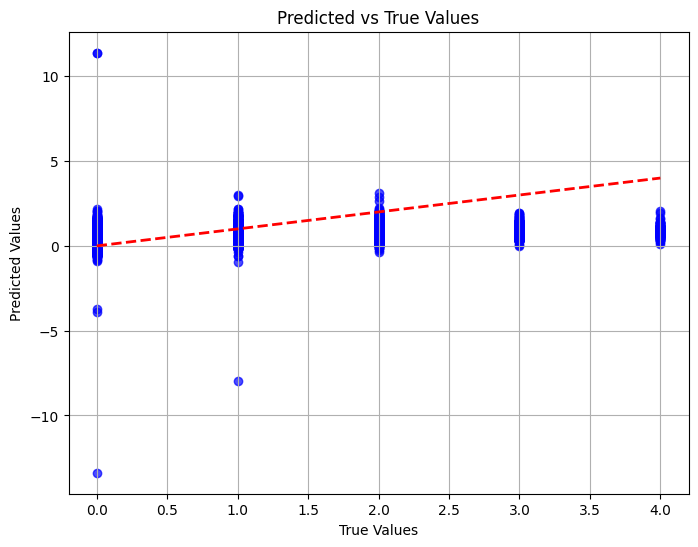

In [ ]:
plt.figure(figsize=(8, 6))  # Set the figure size
plt.scatter(y_test, preds, alpha=0.7, color='blue')  # Scatter plot of true vs. predicted
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)  # Line y=x
plt.title("Predicted vs True Scores")
plt.xlabel("true score")
plt.ylabel("predicted score")
plt.grid(True)
plt.show()

You can see that the true scores are discrete, not continuous, hence the vertical lines on the graph at the integer values 0 to 4. Predicted scores are clearly tending towards the sample mean - no predictions above 2 are made, despite the data holding true scores of 3 and 4.

In the next notebook we look at better ways to evaluate models.